# Libraries & basic config

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import gzip
import time
import matplotlib.ticker as mtick
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
import scipy
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import keras
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.layers import Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

keras.backend.set_floatx('float64')
strikes_dim = 11
%matplotlib inline
os.chdir("data")

# Load data

In [2]:
f = gzip.GzipFile('TrainrBergomiTermStructure.txt.gz', "r")
dat = np.load(f)
xx = dat[:,:11]
yy = dat[:,11:]
print(dat.shape, xx.shape, yy.shape)
strikes = np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5])
maturities = np.array([0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ])

(80000, 99) (80000, 11) (80000, 88)


In [3]:
NumParameters = xx.shape[1]

# Prepare data

In [4]:
X_train, X_test, y_train, y_test = train_test_split(yy, xx, test_size=0.15, random_state=42)

scale = StandardScaler()
scale2 =  StandardScaler()
y_train_transform = scale.fit_transform(y_train)
y_test_transform = scale.transform(y_test)
x_train_transform = scale2.fit_transform(X_train)
x_test_transform = scale2.transform(X_test)

In [5]:
def xtransform(X_train,X_test):
    return [scale2.transform(X_train),scale2.transform(X_test)]

def xinversetransform(x):
    return scale2.inverse_transform(x.reshape(1, -1)).flatten()
    
[x_train_transform,x_test_transform] = xtransform(X_train, X_test)

In [6]:
# Upper and lower bounds used in the training set
ub = [0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16, 0.16,   4,  0, 0.5]
lb = [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.5, -1, 0.025]

def myscale(x):
    res = np.zeros(NumParameters)
    for i in range(NumParameters):
        res[i] = (x[i] - (ub[i] + lb[i]) * 0.5) * 2 / (ub[i] - lb[i])
        
    return res
def myinverse(x):
    res = np.zeros(NumParameters)
    for i in range(NumParameters):
        res[i] = x[i] * (ub[i] - lb[i]) * 0.5 + (ub[i] + lb[i]) * 0.5
        
    return res   

In [7]:
y_train_transform = np.array([myscale(y) for y in y_train])
y_test_transform = np.array([myscale(y) for y in y_test])

In [8]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

# Configurations

In [9]:
configs = [
    {
        'name': 'base_model',
        'layers': [
            {'units': 30, 'activation': 'elu'},
            {'units': 30, 'activation': 'elu'},
            {'units': 30, 'activation': 'elu'},
            {'units': 30, 'activation': 'elu'},
            {'units': 88, 'activation': 'linear'}
        ],
        'optimizer': 'adam',
        'loss_fn': 'root_mean_squared_error',
        'learning_rate': 0.001,
        'batch_size': 32,
        'epochs': 500,
        'patience': 25
    },
    {
        'name': '10_layers',
        'layers': [
            {'units': 30, 'activation': 'elu'},
            {'units': 30, 'activation': 'elu'},
            {'units': 30, 'activation': 'elu'},
            {'units': 30, 'activation': 'elu'},
            {'units': 30, 'activation': 'elu'},
            {'units': 30, 'activation': 'elu'},
            {'units': 30, 'activation': 'elu'},
            {'units': 30, 'activation': 'elu'},
            {'units': 30, 'activation': 'elu'},
            {'units': 30, 'activation': 'elu'},
            {'units': 88, 'activation': 'linear'}
        ],
        'optimizer': 'adam',
        'loss_fn': 'root_mean_squared_error',
        'learning_rate': 0.001,
        'batch_size': 32,
        'epochs': 500,
        'patience': 25
    },
    {
        'name': '20_layers',
        'layers': [
            {'units': 30, 'activation': 'elu'},
            {'units': 30, 'activation': 'elu'},
            {'units': 30, 'activation': 'elu'},
            {'units': 30, 'activation': 'elu'},
            {'units': 30, 'activation': 'elu'},
            {'units': 30, 'activation': 'elu'},
            {'units': 30, 'activation': 'elu'},
            {'units': 30, 'activation': 'elu'},
            {'units': 30, 'activation': 'elu'},
            {'units': 30, 'activation': 'elu'},
            {'units': 30, 'activation': 'elu'},
            {'units': 30, 'activation': 'elu'},
            {'units': 30, 'activation': 'elu'},
            {'units': 30, 'activation': 'elu'},
            {'units': 30, 'activation': 'elu'},
            {'units': 30, 'activation': 'elu'},
            {'units': 30, 'activation': 'elu'},
            {'units': 30, 'activation': 'elu'},
            {'units': 30, 'activation': 'elu'},
            {'units': 30, 'activation': 'elu'},
            {'units': 88, 'activation': 'linear'}
        ],
        'optimizer': 'adam',
        'loss_fn': 'root_mean_squared_error',
        'learning_rate': 0.001,
        'batch_size': 32,
        'epochs': 500,
        'patience': 25
    },
    {
        'name': 'relu',
        'layers': [
            {'units': 50, 'activation': 'relu'},
            {'units': 50, 'activation': 'relu'},
            {'units': 50, 'activation': 'relu'},
            {'units': 50, 'activation': 'relu'},
            {'units': 88, 'activation': 'linear'}
        ],
        'optimizer': 'adam',
        'loss_fn': 'root_mean_squared_error',
        'learning_rate': 0.001,
        'batch_size': 32,
        'epochs': 500,
        'patience': 25
    },   
    {
        'name': '1_layer',
        'layers': [
            {'units': 30, 'activation': 'elu'},
            {'units': 88, 'activation': 'linear'}
        ],
        'optimizer': 'adam',
        'loss_fn': 'root_mean_squared_error',
        'learning_rate': 0.001,
        'batch_size': 32,
        'epochs': 500,
        'patience': 25
    },
    {
        'name': '2_layers',
        'layers': [
            {'units': 30, 'activation': 'elu'},
            {'units': 30, 'activation': 'elu'},
            {'units': 88, 'activation': 'linear'}
        ],
        'optimizer': 'adam',
        'loss_fn': 'root_mean_squared_error',
        'learning_rate': 0.001,
        'batch_size': 32,
        'epochs': 500,
        'patience': 25
    },
    {
        'name': '3_layers',
        'layers': [
            {'units': 30, 'activation': 'elu'},
            {'units': 30, 'activation': 'elu'},
            {'units': 30, 'activation': 'elu'},
            {'units': 88, 'activation': 'linear'}
        ],
        'optimizer': 'adam',
        'loss_fn': 'root_mean_squared_error',
        'learning_rate': 0.001,
        'batch_size': 32,
        'epochs': 500,
        'patience': 25
    },
    {
        'name': '40_neurons',
        'layers': [
            {'units': 40, 'activation': 'elu'},
            {'units': 40, 'activation': 'elu'},
            {'units': 40, 'activation': 'elu'},
            {'units': 40, 'activation': 'elu'},
            {'units': 88, 'activation': 'linear'}
        ],
        'optimizer': 'adam',
        'loss_fn': 'root_mean_squared_error',
        'learning_rate': 0.001,
        'batch_size': 32,
        'epochs': 500,
        'patience': 25
    },
    {
        'name': '50_neurons',
        'layers': [
            {'units': 50, 'activation': 'elu'},
            {'units': 50, 'activation': 'elu'},
            {'units': 50, 'activation': 'elu'},
            {'units': 50, 'activation': 'elu'},
            {'units': 88, 'activation': 'linear'}
        ],
        'optimizer': 'adam',
        'loss_fn': 'root_mean_squared_error',
        'learning_rate': 0.001,
        'batch_size': 32,
        'epochs': 500,
        'patience': 25
    },
    {
        'name': '40_neurons',
        'layers': [
            {'units': 60, 'activation': 'elu'},
            {'units': 60, 'activation': 'elu'},
            {'units': 60, 'activation': 'elu'},
            {'units': 60, 'activation': 'elu'},
            {'units': 88, 'activation': 'linear'}
        ],
        'optimizer': 'adam',
        'loss_fn': 'root_mean_squared_error',
        'learning_rate': 0.001,
        'batch_size': 32,
        'epochs': 500,
        'patience': 25
    },
]

# Create the Neural Network

In [10]:
def create_neural_network(config):
    input_layer = keras.layers.Input(shape=(NumParameters,))
    x = input_layer

    for layer_config in config['layers']:
        x = keras.layers.Dense(units=layer_config['units'], activation=layer_config['activation'])(x)
    
    model = keras.models.Model(inputs=input_layer, outputs=x)

    optimizer = config['optimizer']
    if optimizer == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=config['learning_rate'])

    model.compile(loss=root_mean_squared_error, optimizer=optimizer)

    return model

# Fit the Neural Network

In [11]:
def train_neural_network(model, config, y_train, x_train, y_val, x_val):
    earlystop = EarlyStopping(monitor="val_loss",
                              min_delta=0,
                              mode="min",
                              verbose=False, 
                              patience=config['patience'])

    model.fit(y_train, x_train, batch_size=config['batch_size'], validation_data=(y_val, x_val), epochs=config['epochs'], verbose=False, shuffle=1, callbacks=[earlystop])

# Obtain trained models

In [12]:
def run_experiments(configs, y_train, x_train, y_val, x_val):
        models = []
        for idx, config in enumerate(configs):
                print(f"Running configuration {idx + 1}/{len(configs)}.")
                model = create_neural_network(config)
                print(f"Created neural network {idx + 1} for {config['name']}.")
                model.summary()
                train_neural_network(model, config, y_train, x_train, y_val, x_val)
                print(f"Fitted neural network {idx + 1}.")
                models.append(model)
        return models

In [13]:
trained_models = run_experiments(configs, y_train_transform, x_train_transform, y_test_transform, x_test_transform)

Running configuration 1/4.
Created neural network 1 for base_model.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 11)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 30)             │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 88)             │         2,728 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,878 (45.92 KB)

 Trainable params: 5,878 (45.92 KB)

 Non-trainable params: 0 (0.00 B)

Fitted neural network 1.
Running configuration 2/4.
Created neural network 2 for 10_layers.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 11)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 30)             │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 88)             │         2,728 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,388 (96.78 KB)

 Trainable params: 12,388 (96.78 KB)

 Non-trainable params: 0 (0.00 B)

Fitted neural network 2.
Running configuration 3/4.
Created neural network 3 for 20_layers.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 11)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 30)             │           360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 30)             │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 88)             │         2,728 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,688 (169.44 KB)

 Trainable params: 21,688 (169.44 KB)

 Non-trainable params: 0 (0.00 B)

Fitted neural network 3.
Running configuration 4/4.
Created neural network 4 for relu.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 11)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 50)             │           600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 88)             │         4,488 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,738 (99.52 KB)

 Trainable params: 12,738 (99.52 KB)

 Non-trainable params: 0 (0.00 B)

Fitted neural network 4.


## Store optimal NN parameters

In [14]:
# NNParameters = []
# for i in range(1,len(modelGEN.layers)):
#     NNParameters.append(modelGEN.layers[i].get_weights())

def get_model_parameters(model):
    NNParameters = []
    for layer in model.layers[1:]:  # Skip the input layer
        NNParameters.append(layer.get_weights())
    return NNParameters

# Hardcode the Neural Network in NUMPY for performance improvement

In [15]:
def elu(x):
    # Careful, function overwrites x
    ind = (x<0)
    x[ind] = np.exp(x[ind])-1
    return x

def eluPrime(y):
    # we make a deep copy of input x
    x = np.copy(y)
    ind = (x < 0)
    x[ind] = np.exp(x[ind])
    x[~ind] = 1
    return x

def NeuralNetwork(x, n_layers, nn_parameters):
    input1 = x
    for i in range(n_layers):
        input1 = np.dot(input1, nn_parameters[i][0]) + nn_parameters[i][1]
        #Elu activation
        input1 = elu(input1)
    #The output layer is linnear
    i+=1
    return np.dot(input1, nn_parameters[i][0]) + nn_parameters[i][1]

def NeuralNetworkGradient(x, n_layers, nn_parameters):
    input1 = x
    #Identity Matrix represents Jacobian with respect to initial parameters
    grad = np.eye(NumParameters)
    #Propagate the gradient via chain rule
    for i in range(n_layers):
        input1 = (np.dot(input1, nn_parameters[i][0]) + nn_parameters[i][1])
        grad=(np.einsum('ij,jk->ik', grad, nn_parameters[i][0]))
        #Elu activation
        grad*=eluPrime(input1)
        input1 = elu(input1)
    #input1.append(np.dot(input1[i],NNParameters[i+1][0])+NNParameters[i+1][1])
    grad = np.einsum('ij,jk->ik', grad, nn_parameters[i+1][0])
    #grad stores all intermediate Jacobians, however only the last one is used here as output
    return grad        

# Compute Implied vol relative errors on Test set

In [16]:
def CostFunc(x, sample_ind, n_layers, nn_parameters):
    return np.sum(np.power((NeuralNetwork(x, n_layers, nn_parameters) - x_test_transform[sample_ind]), 2))
def Jacobian(x, sample_ind, n_layers, nn_parameters):
    return 2 * np.sum((NeuralNetwork(x, n_layers, nn_parameters) - x_test_transform[sample_ind]) * NeuralNetworkGradient(x, n_layers, nn_parameters), axis=1)
#Cost Function for Levenberg Marquardt
def CostFuncLS(x, sample_ind, n_layers, nn_parameters):
    return (NeuralNetwork(x, n_layers, nn_parameters) - x_test_transform[sample_ind])
def JacobianLS(x, sample_ind, n_layers, nn_parameters):
    return NeuralNetworkGradient(x, n_layers, nn_parameters).T

In [17]:
def evaluate_models(trained_models, configs, X_test, y_test_transform, strikes, maturities):
    maturities_dim = len(maturities)
    strikes_dim = len(strikes)
    CalibratedParameters = []
    Timing = []

    for model_idx, model in enumerate(trained_models):
        model_name = configs[model_idx]['name']
        print(f"Evaluating model {model_idx + 1}: {model_name}")
        NNParameters = get_model_parameters(model)
        NumLayers = len(model.layers) - 2
        print(f"We have {NumLayers} layers in {model_name}!")
        
        X_sample = X_test
        y_sample = y_test_transform

        prediction = [xinversetransform(NeuralNetwork(y_sample[i], NumLayers, NNParameters)) for i in range(len(y_sample))]

        plt.figure(1, figsize=(14, 4))
        ax = plt.subplot(1, 3, 1)
        err = np.mean(100 * np.abs((X_sample - prediction) / X_sample), axis=0)
        plt.title("Average relative error for {model_name}", fontsize=15, y=1.04)
        plt.imshow(err.reshape(maturities_dim, strikes_dim))
        plt.colorbar(format=mtick.PercentFormatter())
        ax.set_xticks(np.linspace(0, len(strikes) - 1, len(strikes)))
        ax.set_xticklabels(strikes)
        ax.set_yticks(np.linspace(0, len(maturities) - 1, len(maturities)))
        ax.set_yticklabels(maturities)
        plt.xlabel("Strike", fontsize=15, labelpad=5)
        plt.ylabel("Maturity", fontsize=15, labelpad=5)

        ax = plt.subplot(1, 3, 2)
        err = 100 * np.std(np.abs((X_sample - prediction) / X_sample), axis=0)
        plt.title("Std relative error for {model_name}", fontsize=15, y=1.04)
        plt.imshow(err.reshape(maturities_dim, strikes_dim))
        plt.colorbar(format=mtick.PercentFormatter())
        ax.set_xticks(np.linspace(0, len(strikes) - 1, len(strikes)))
        ax.set_xticklabels(strikes)
        ax.set_yticks(np.linspace(0, len(maturities) - 1, len(maturities)))
        ax.set_yticklabels(maturities)
        plt.xlabel("Strike", fontsize=15, labelpad=5)
        plt.ylabel("Maturity", fontsize=15, labelpad=5)

        ax = plt.subplot(1, 3, 3)
        err = 100 * np.max(np.abs((X_sample - prediction) / X_sample), axis=0)
        plt.title("Maximum relative error for {model_name}", fontsize=15, y=1.04)
        plt.imshow(err.reshape(maturities_dim, strikes_dim))
        plt.colorbar(format=mtick.PercentFormatter())
        ax.set_xticks(np.linspace(0, len(strikes) - 1, len(strikes)))
        ax.set_xticklabels(strikes)
        ax.set_yticks(np.linspace(0, len(maturities) - 1, len(maturities)))
        ax.set_yticklabels(maturities)
        plt.xlabel("Strike", fontsize=15, labelpad=5)
        plt.ylabel("Maturity", fontsize=15, labelpad=5)
        plt.tight_layout()
        plt.savefig(f'rBergomiTermStructureNNErrors_Model_{model_name}_{model_idx + 1}.PNG', dpi=300)
        plt.show()

        S0 = 1.
        sample_ind = 250
        X_sample = X_test[sample_ind]
        y_sample = y_test_transform[sample_ind]
        prediction = xinversetransform(NeuralNetwork(y_sample, NumLayers, NNParameters))

        plt.figure(1, figsize=(14, 12))
        for i in range(maturities_dim):
            plt.subplot(4, 4, i + 1)
            plt.plot(np.log(strikes / S0), X_sample[i * strikes_dim:(i + 1) * strikes_dim], 'b', label="Input data")
            plt.plot(np.log(strikes / S0), prediction[i * strikes_dim:(i + 1) * strikes_dim], '--r', label=" NN Approx")
            plt.title(f"Maturity={maturities[i]:1.2f}")
            plt.xlabel("log-moneyness")
            plt.ylabel("Implied vol")
            plt.legend()
        plt.tight_layout()
        plt.show()

        print("Model Parameters for {model_name}: ", myinverse(y_sample))

        # Optimization
        model_solutions = []
        model_timing = []
        init = np.zeros(NumParameters)

        for i in range(5000):
            disp = str(i+1)+"/5000"
            print(disp, end="\r")
            # L-BFGS-B
            start = time.perf_counter()
            I = scipy.optimize.minimize(CostFunc, x0=init, args=(i, NumLayers, NNParameters), method='L-BFGS-B', jac=Jacobian, tol=1E-10, options={"maxiter":5000})
            end = time.perf_counter()
            solutions = np.zeros([4, NumParameters])
            times = np.zeros(4)
            solutions[0, :] = myinverse(I.x)
            times[0] = end - start
            # SLSQP
            start = time.perf_counter()
            I = scipy.optimize.minimize(CostFunc, x0=init, args=(i, NumLayers, NNParameters), method='SLSQP', jac=Jacobian, tol=1E-10, options={"maxiter":5000})
            end = time.perf_counter()
            solutions[1, :] = myinverse(I.x)
            times[1] = end - start
            # BFGS
            start = time.perf_counter()
            I = scipy.optimize.minimize(CostFunc, x0=init, args=(i, NumLayers, NNParameters), method='BFGS', jac=Jacobian, tol=1E-10, options={"maxiter":5000})
            end = time.perf_counter()
            solutions[2, :] = myinverse(I.x)
            times[2] = end - start
            # Levenberg-Marquardt
            start = time.perf_counter()
            I = scipy.optimize.least_squares(CostFuncLS, init, JacobianLS, args=(i, NumLayers, NNParameters), gtol=1E-10)
            end = time.perf_counter()
            solutions[3, :] = myinverse(I.x)
            times[3] = end - start
            
            model_solutions.append(np.copy(solutions))
            model_timing.append(np.copy(times))

        CalibratedParameters.append(model_solutions)
        Timing.append(model_timing)

    return CalibratedParameters, Timing

Evaluating model 1
We have 4 layers!


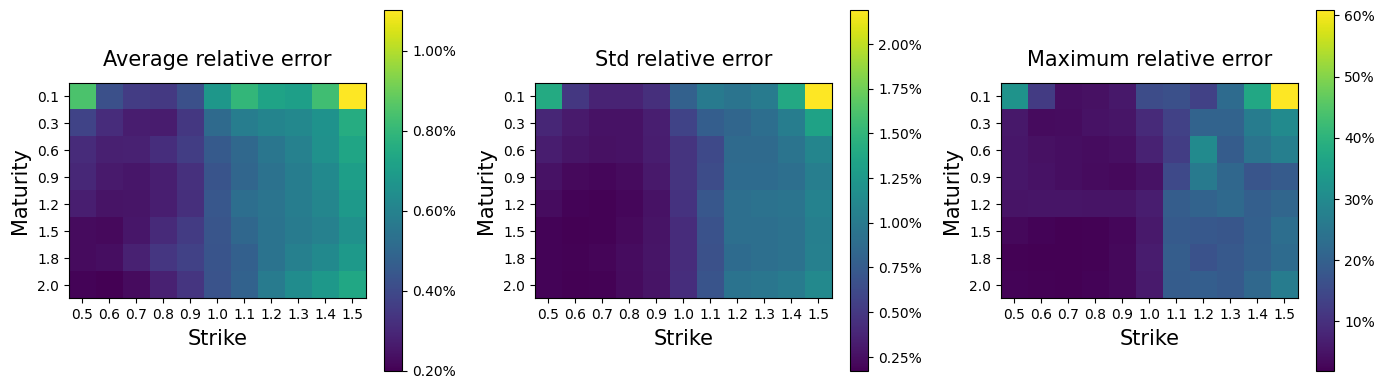

Plotting sample smiles!


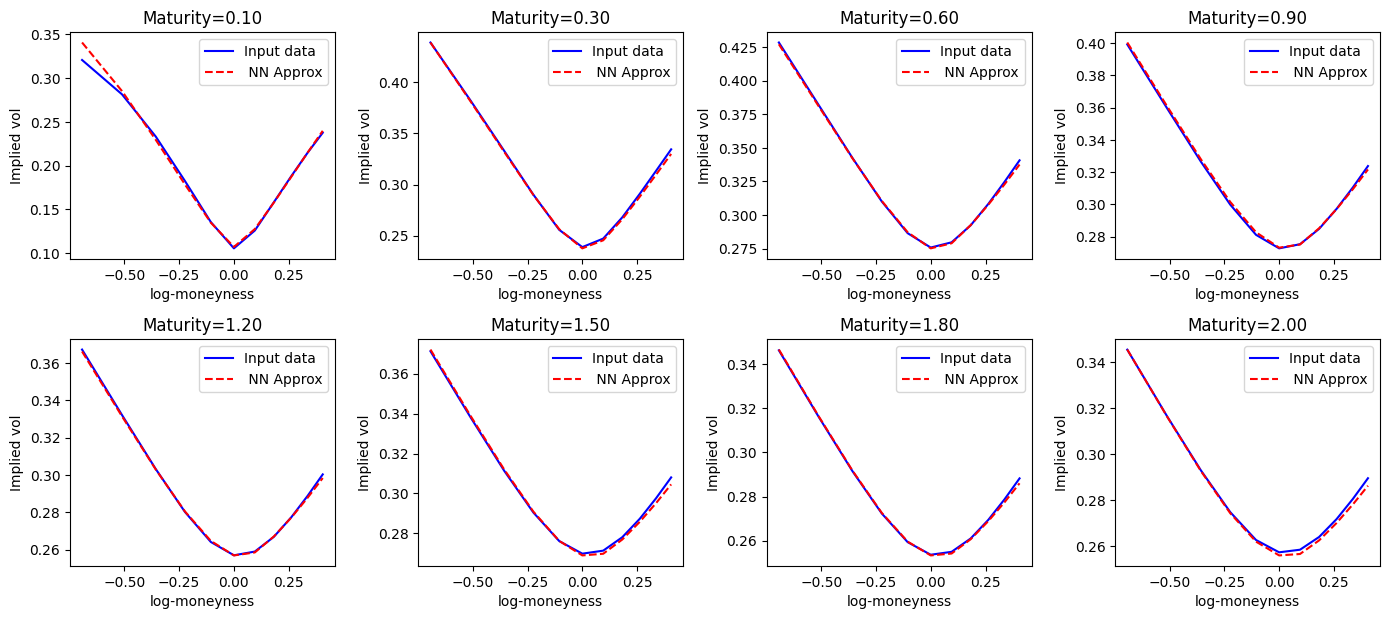

Model Parameters:  [ 0.0120208  0.0992092  0.126305   0.0995428  0.0581061  0.157695
  0.0340984  0.137483   1.63103   -0.060068   0.227925 ]
Evaluating model 2
We have 11 layers!


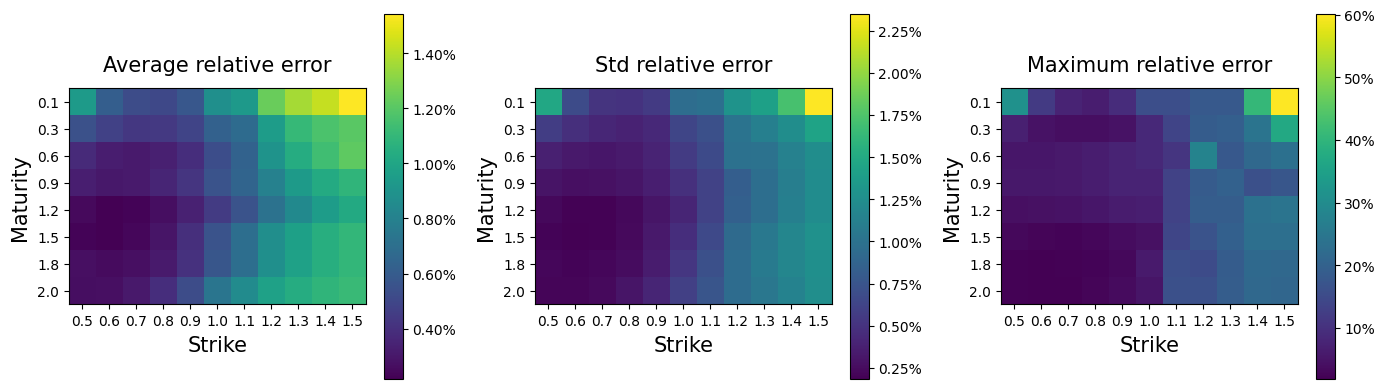

Plotting sample smiles!


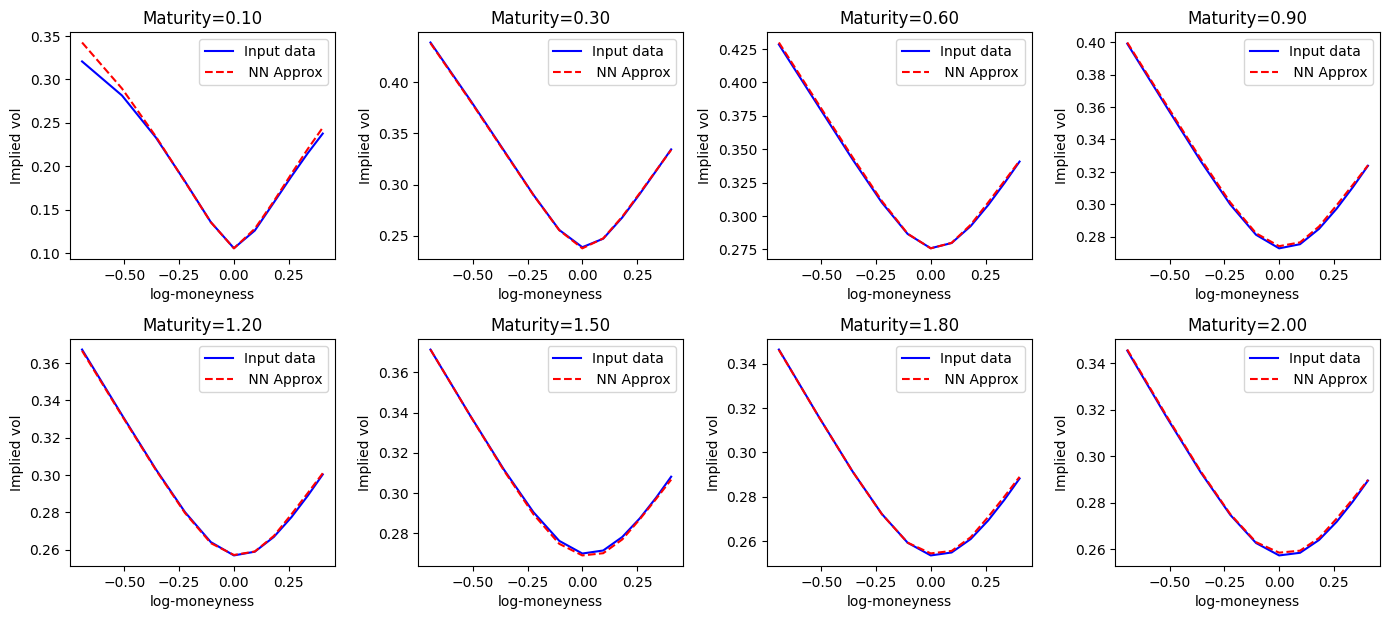

Model Parameters:  [ 0.0120208  0.0992092  0.126305   0.0995428  0.0581061  0.157695
  0.0340984  0.137483   1.63103   -0.060068   0.227925 ]
Evaluating model 3
We have 21 layers!


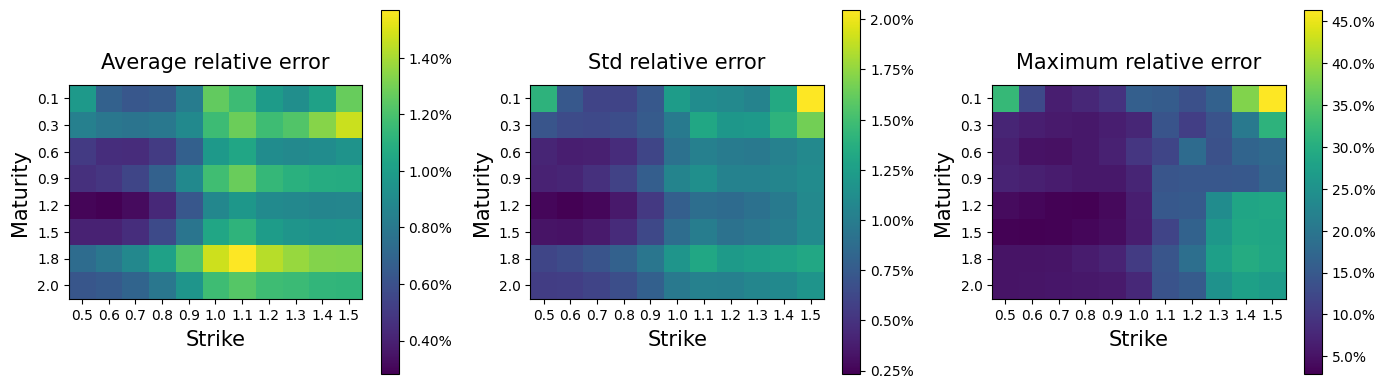

Plotting sample smiles!


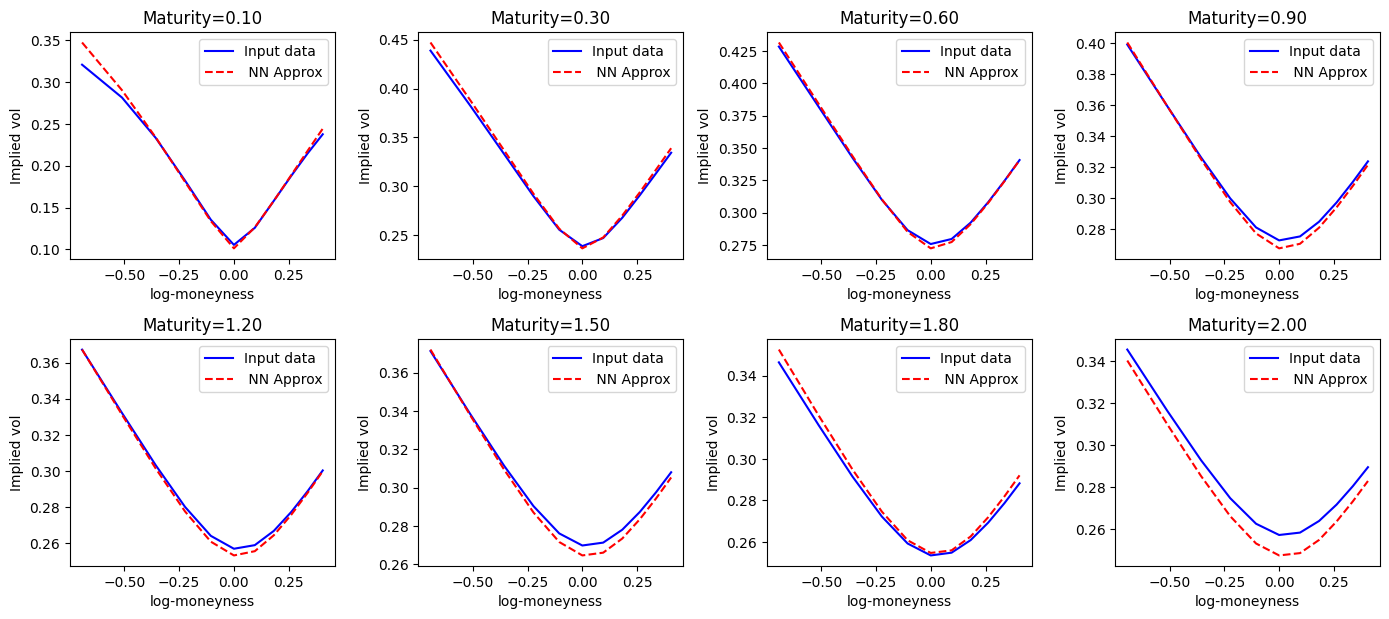

Model Parameters:  [ 0.0120208  0.0992092  0.126305   0.0995428  0.0581061  0.157695
  0.0340984  0.137483   1.63103   -0.060068   0.227925 ]
Evaluating model 4
We have 4 layers!


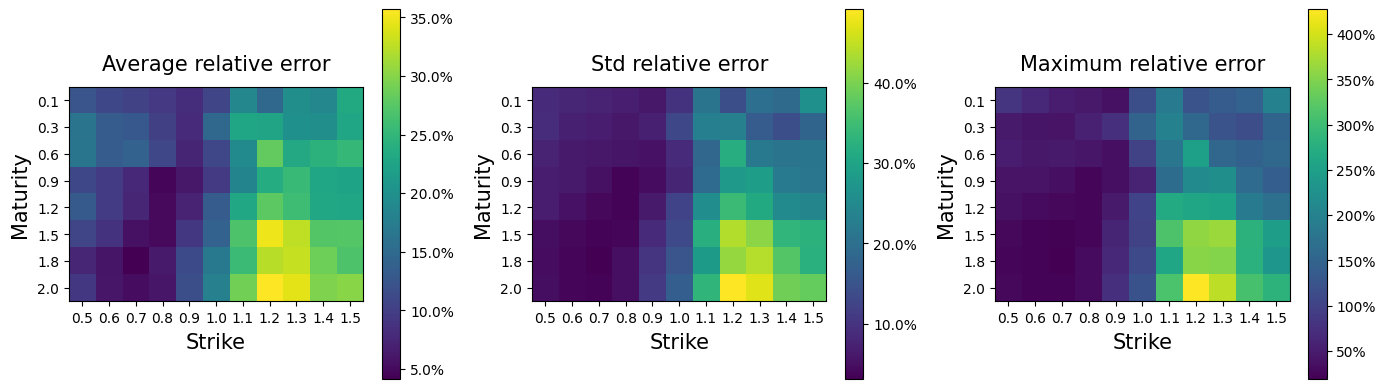

Plotting sample smiles!


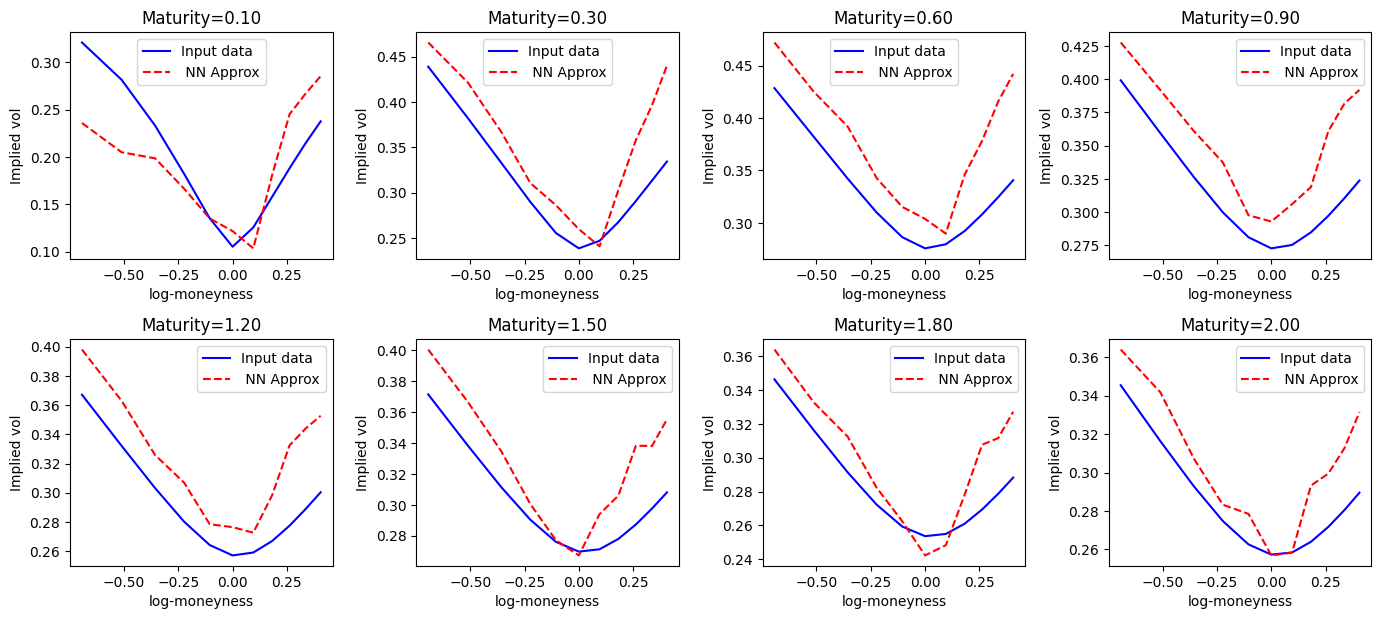

Model Parameters:  [ 0.0120208  0.0992092  0.126305   0.0995428  0.0581061  0.157695
  0.0340984  0.137483   1.63103   -0.060068   0.227925 ]


In [18]:
params, timing = evaluate_models(trained_models, configs, X_test, y_test_transform, strikes, maturities)

# Plot calibration times

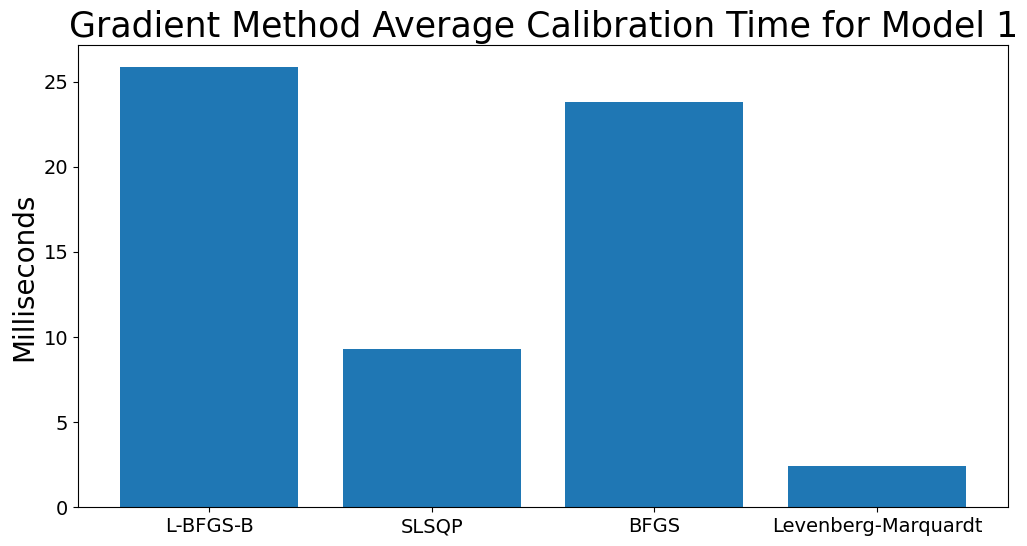

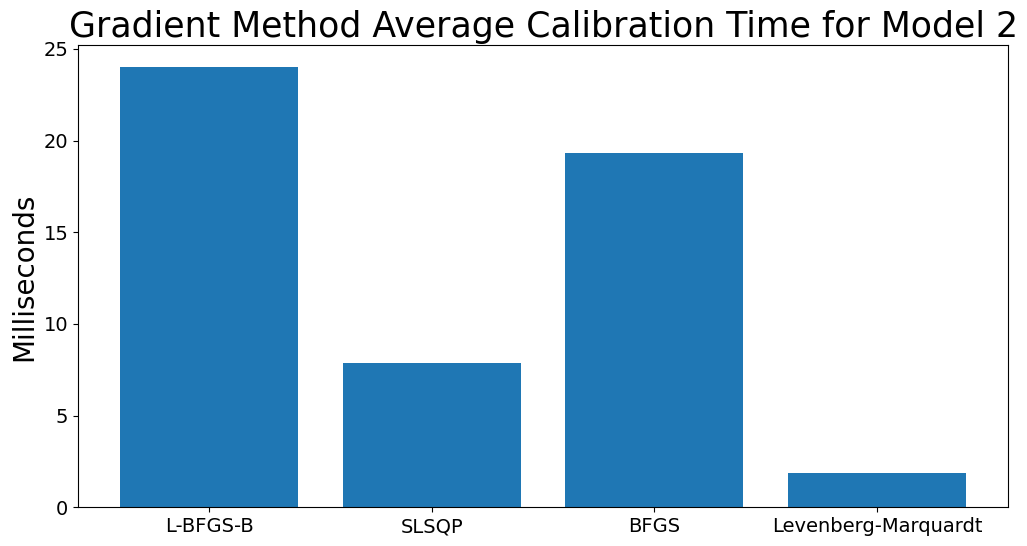

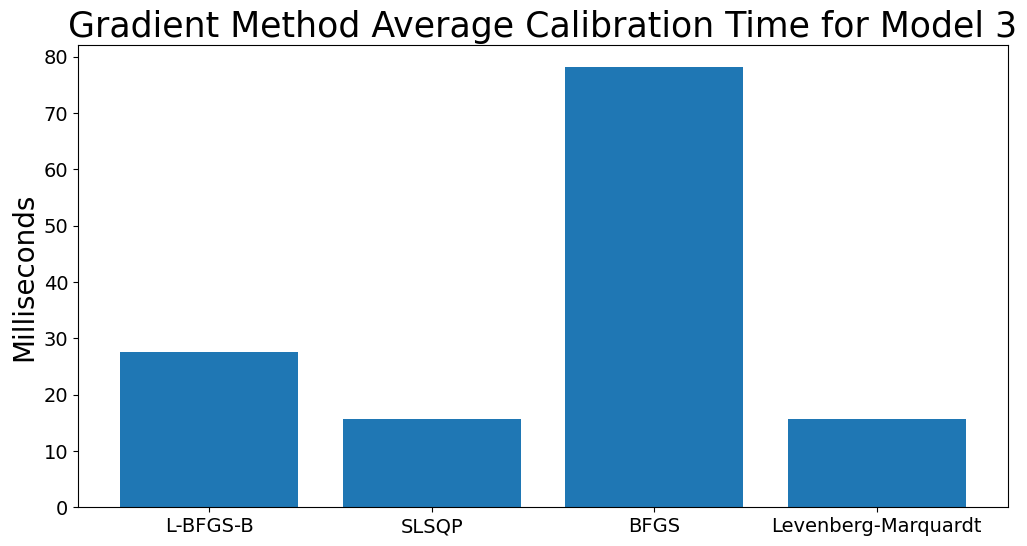

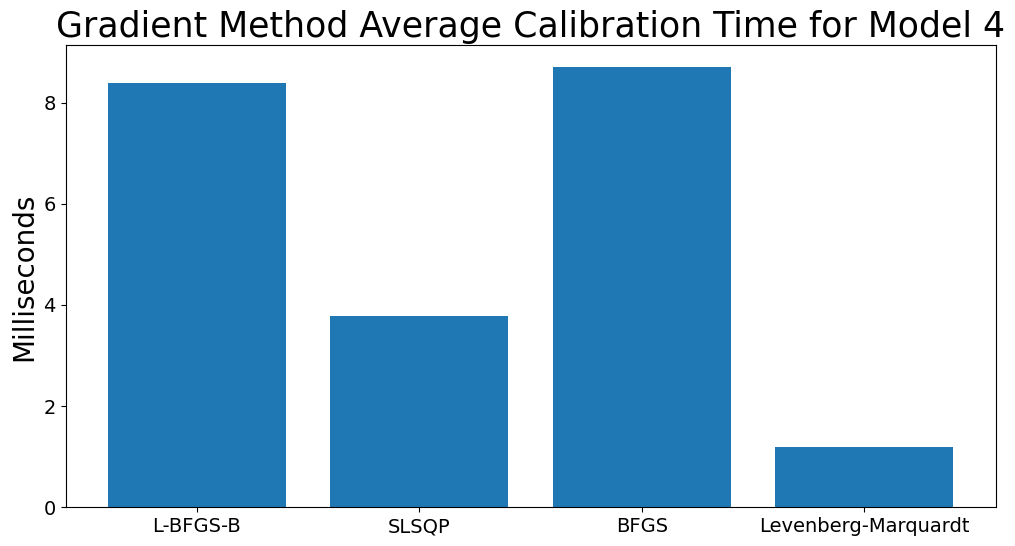

In [19]:
methods = ["L-BFGS-B", "SLSQP", "BFGS", "Levenberg-Marquardt"]

# Loop through each model's timing results and create a separate plot
for model_idx, model_timing in enumerate(timing):
    mean_timing = np.mean(model_timing, axis=0)
    
    plt.figure(figsize=(12, 6))
    plt.bar(methods, [t * 1000 for t in mean_timing])
    plt.title(f"Gradient Method Average Calibration Time for Model {model_idx + 1}", fontsize=25)
    plt.ylabel("Milliseconds", fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.show()

# Plot relative errors for levenberg-Marquardt optimal parameters

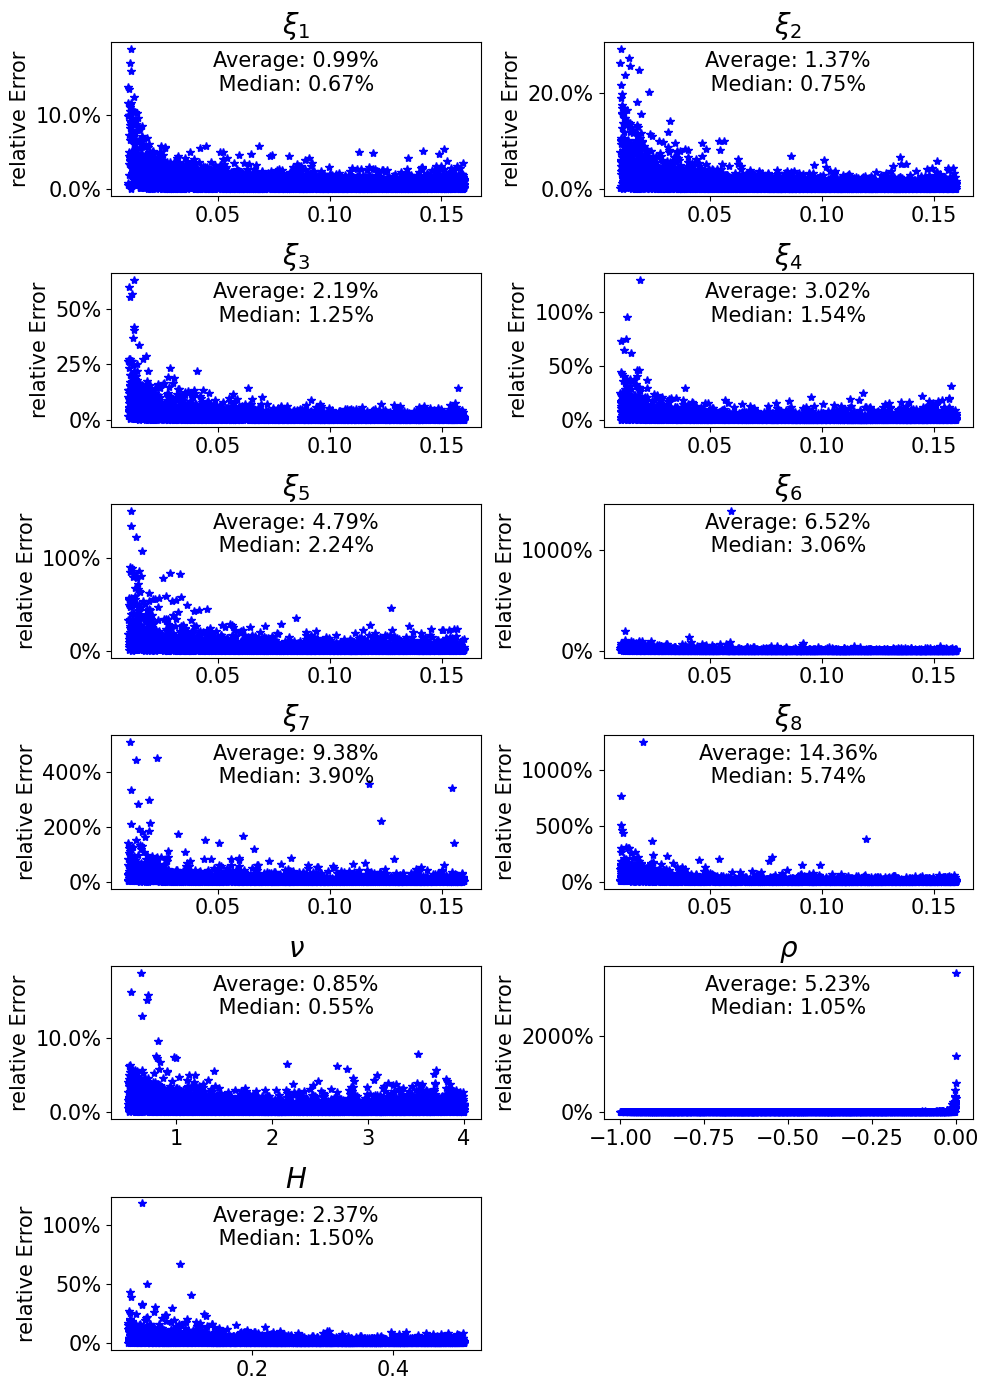

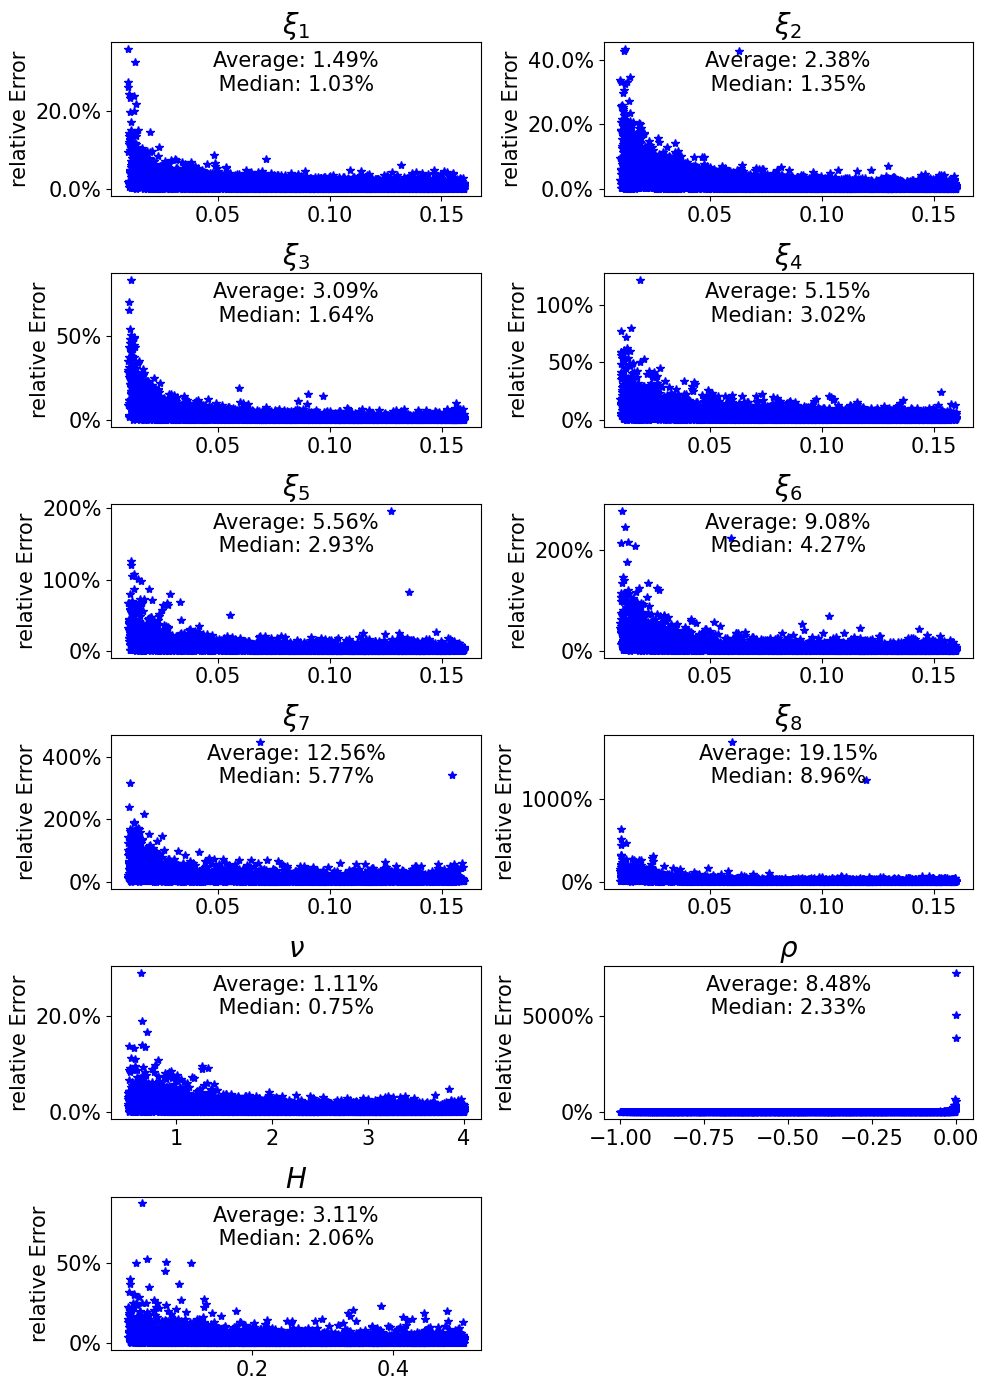

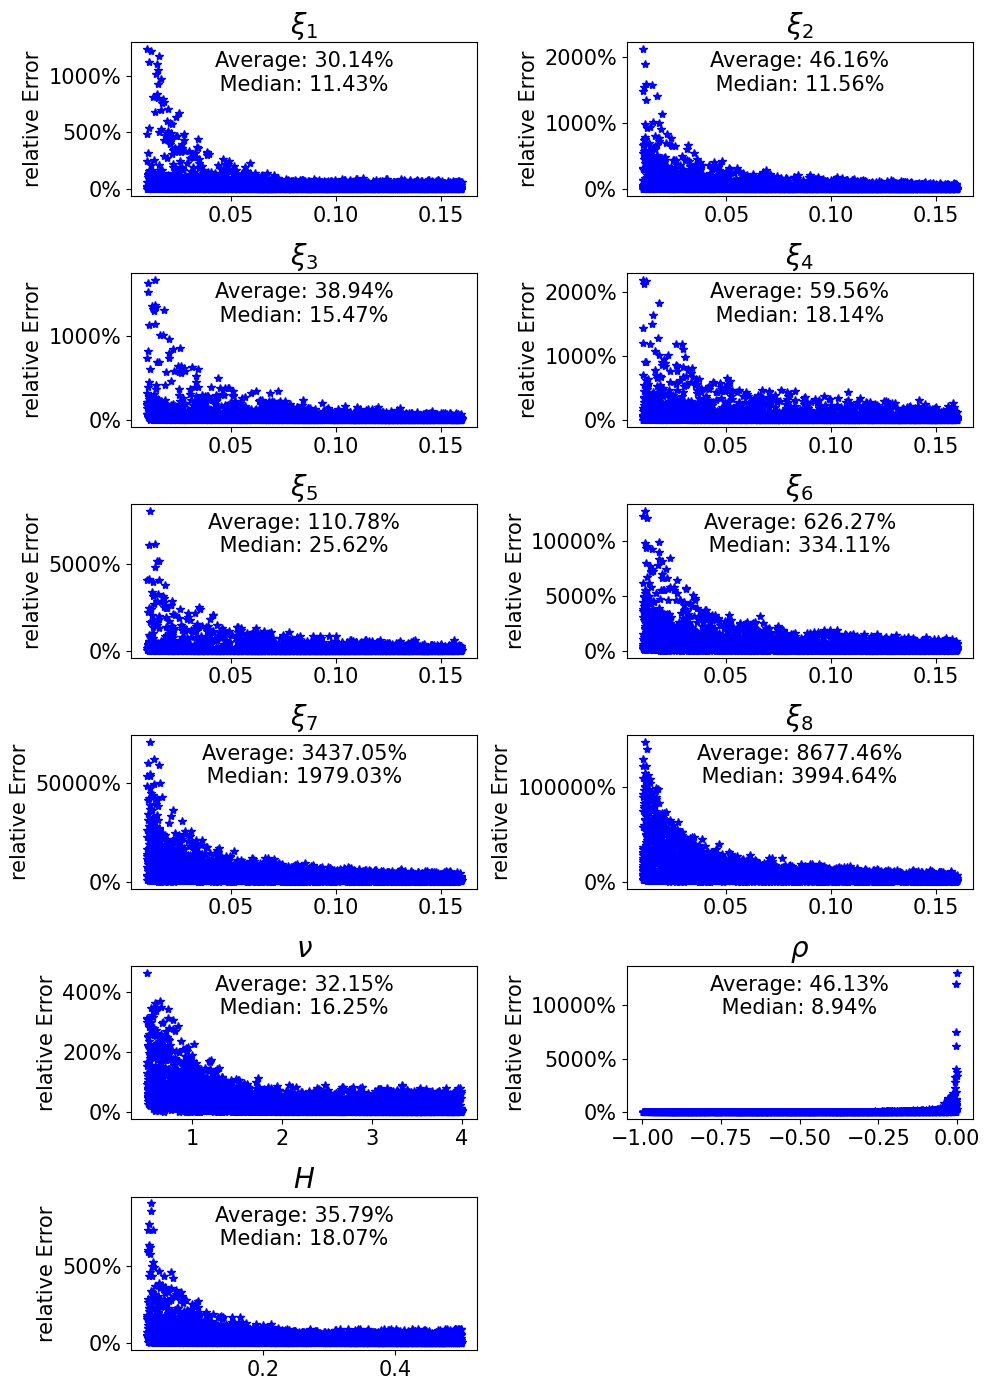

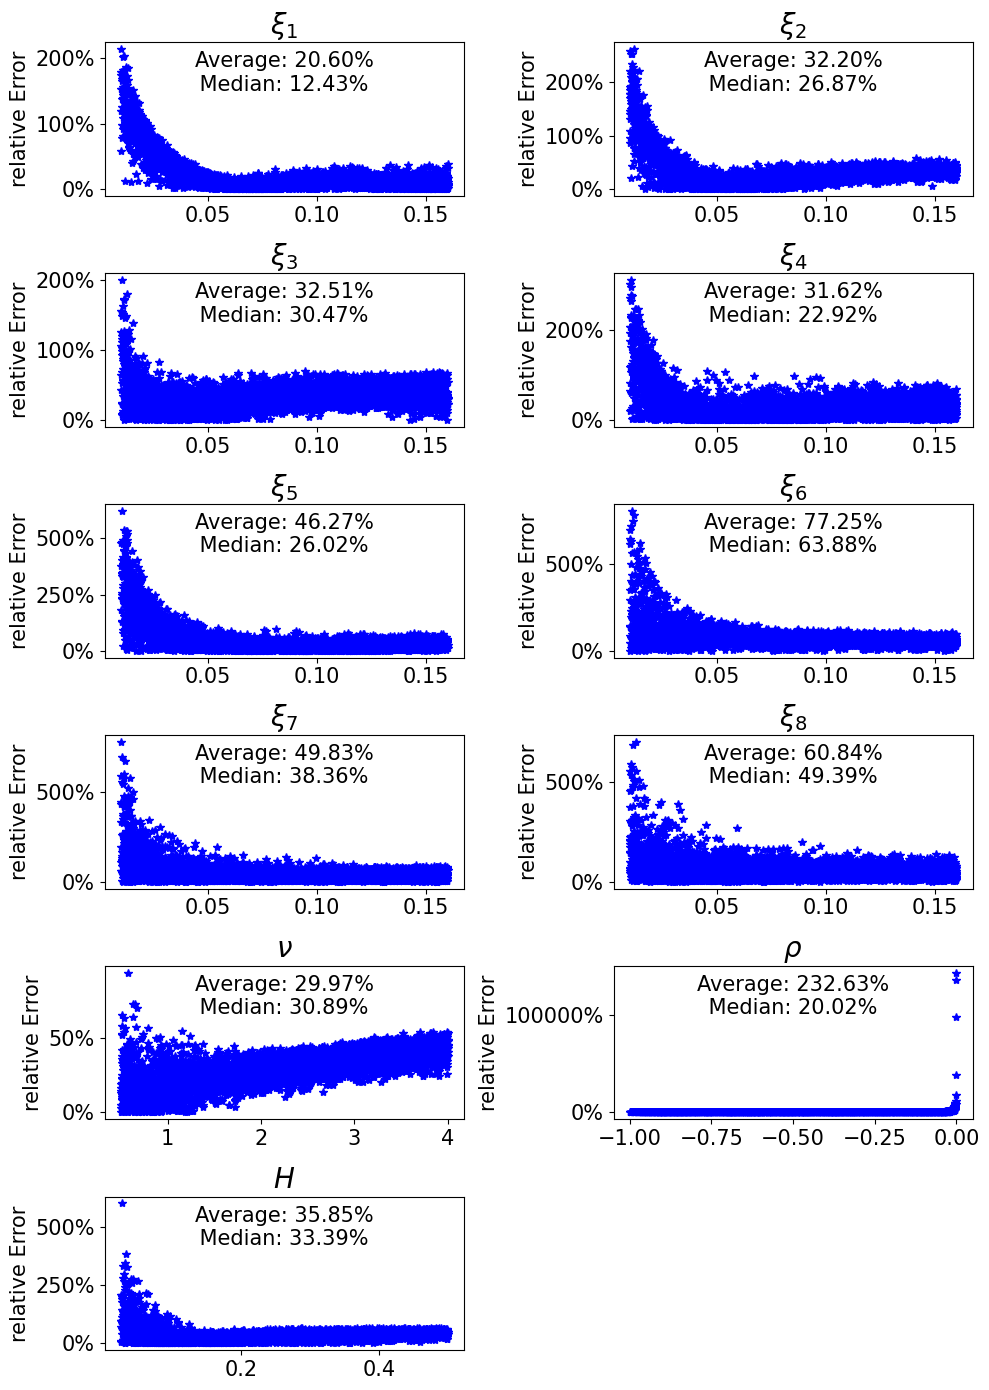

In [20]:
titles = ["$\\xi_1$", "$\\xi_2$", "$\\xi_3$", "$\\xi_4$", "$\\xi_5$", "$\\xi_6$", "$\\xi_7$", "$\\xi_8$", "$\\nu$", "$\\rho$", "$H$"]

# Loop over each set of parameters (each model configuration)
for model_idx, model_params_set in enumerate(params):
    fig = plt.figure(figsize=(10, 14))
    average = np.zeros([11, 5000])
    
    for u in range(11):
        ax = plt.subplot(6, 2, u + 1)
        for i in range(5000):
            y = y_test[i][u]
            plt.plot(y, 100 * np.abs(model_params_set[i][3][u] - y) / np.abs(y), 'b*')
            average[u, i] = np.abs(model_params_set[i][3][u] - y) / np.abs(y)
        
        plt.title(titles[u], fontsize=20)
        plt.ylabel('relative Error', fontsize=15)
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
        plt.tick_params(axis='both', which='major', labelsize=15)
        plt.tick_params(axis='both', which='minor', labelsize=15)
        plt.text(0.5, 0.8, 'Average: %1.2f%%\n Median: %1.2f%% ' % (np.mean(100 * average[u, :]), np.quantile(100 * average[u, :], 0.5)), horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=15)
    
    plt.tight_layout()
    plt.savefig(f'rBergomiTermStructureParameterRelativeErrors_Model_{model_idx + 1}.png', dpi=300)
    plt.show()


# Compare calibrated surfaces to original ones

In [21]:
# Load surfaces generated using optimal parameters
SurfacesCalib = np.loadtxt("surfacesFromNNRoughBergomiTermStructure.txt")
SurfacesCalib = SurfacesCalib[:,11:]
SurfacesTarget = X_test[:5000]
#We drop indices that don't give implied vols due to MC error
RMSENN = np.sqrt(np.mean(np.power(SurfacesCalib-SurfacesTarget, 2), axis=1))
ind = ~(RMSENN==np.inf)
RMSENN = RMSENN[ind]
len(RMSENN)

C:\Users\ole\AppData\Local\Temp\ipykernel_21996\911152018.py:6: RuntimeWarning: overflow encountered in power
  RMSENN = np.sqrt(np.mean(np.power(SurfacesCalib-SurfacesTarget, 2), axis=1))


4941

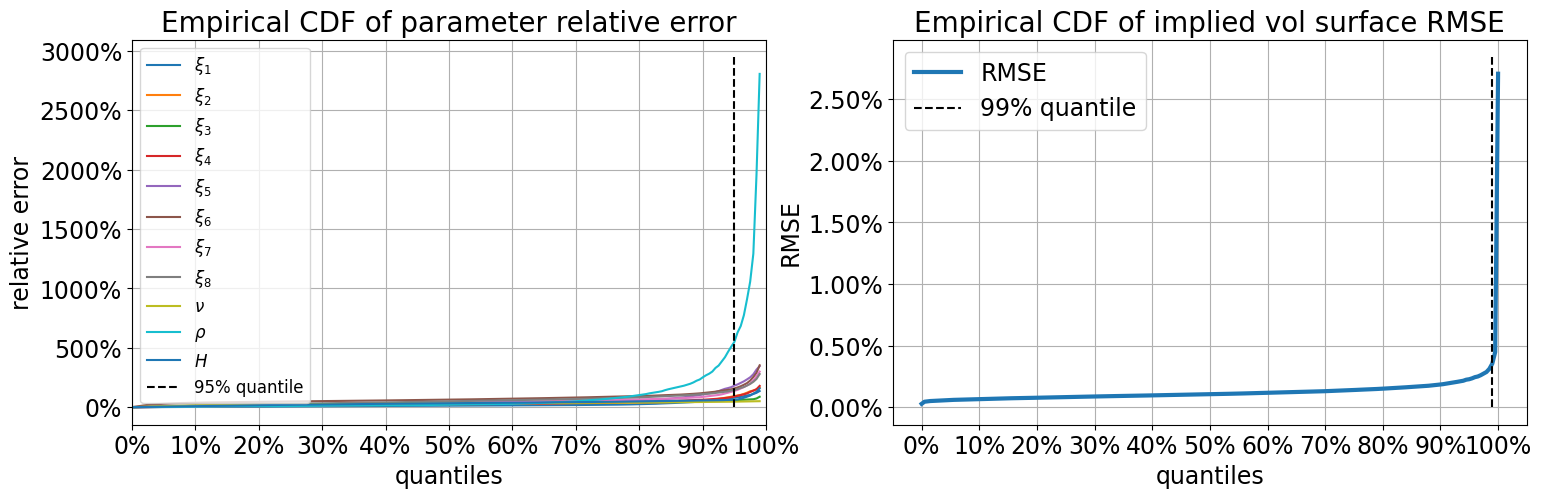

In [22]:
plt.figure(figsize=(18, 5))
plt.clf()
plt.subplot(121)

ax = plt.gca()
q=np.linspace(0,0.99,200)
for u in range(11):
    p=plt.plot(100*q,np.quantile(100*average[u,:],q),label=titles[u])    
    c=p[0].get_color()
ymin, ymax = ax.get_ylim()
ax.set_xlim(0,100)
plt.plot(100*np.ones(2)*0.95,np.array([0,ymax]),'--k',label="95% quantile")
plt.title("Empirical CDF of parameter relative error",fontsize=20)
plt.legend(fontsize=12)
plt.xlabel("quantiles",fontsize=17)
plt.ylabel("relative error",fontsize=17)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter() )
plt.tick_params(axis='both', which='major', labelsize=17)
plt.tick_params(axis='both', which='minor', labelsize=17)
plt.xticks(np.arange(0, 101, step=10))

plt.grid()
plt.subplot(122)


ax = plt.gca()
q=np.linspace(0,1,200)
p=plt.plot(100*q,np.quantile(100*RMSENN,q),linewidth=3,label="RMSE")
ymin, ymax = ax.get_ylim()
plt.plot(100*np.ones(2)*0.99,np.array([0,ymax]),'--k',label="99% quantile")
plt.title("Empirical CDF of implied vol surface RMSE",fontsize=20)
plt.legend(fontsize=17)
plt.xlabel("quantiles",fontsize=17)
plt.ylabel("RMSE",fontsize=17)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter() )
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter() )
plt.tick_params(axis='both', which='major', labelsize=17)
plt.tick_params(axis='both', which='minor', labelsize=17)
plt.xticks(np.arange(0, 101, step=10))
plt.grid()
plt.savefig('rBergomiTermStructureErrorCDF.png', dpi=300)
plt.show()